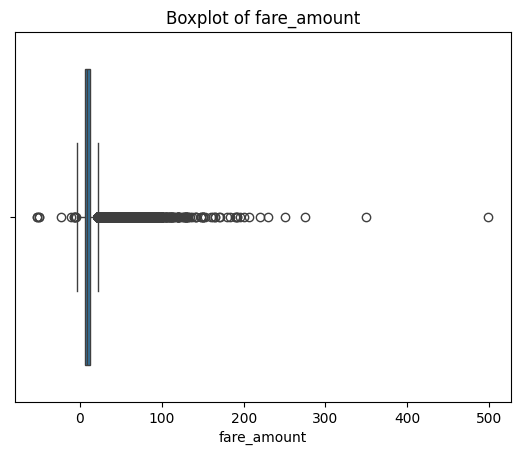

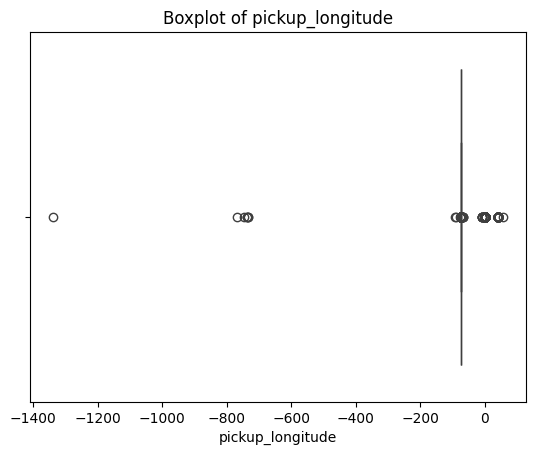

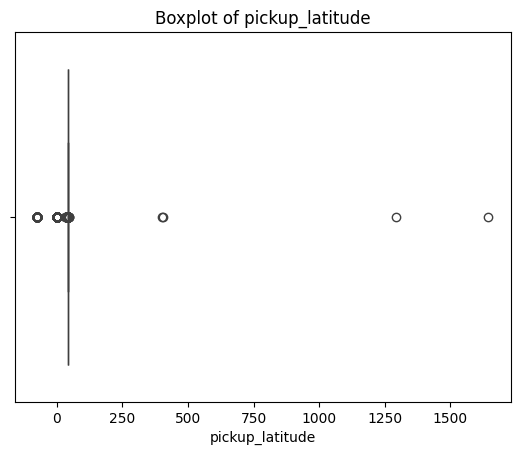

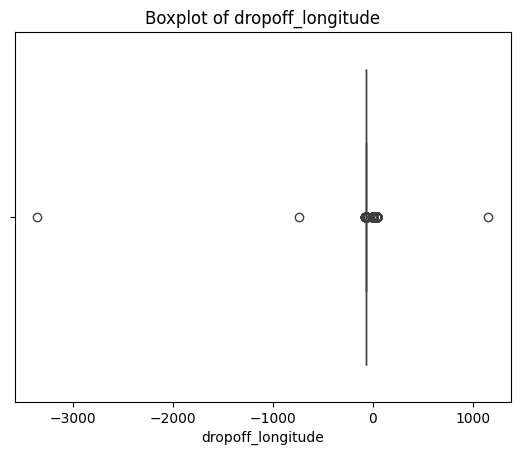

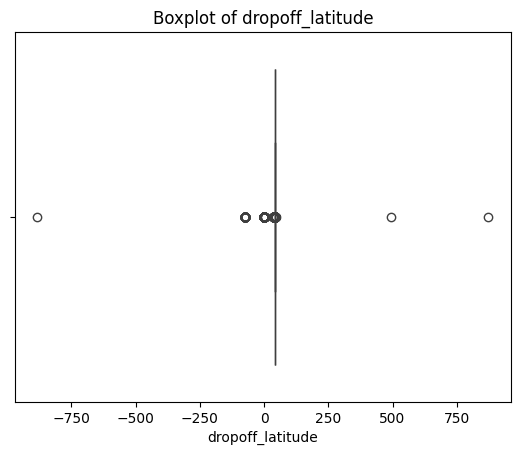

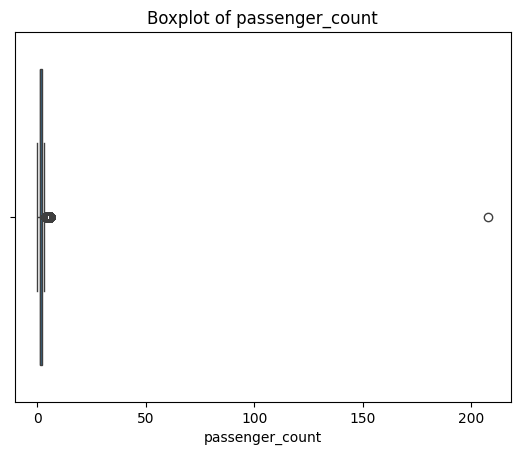

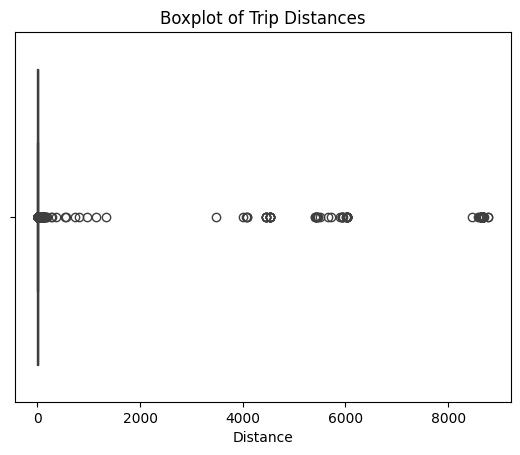

                 fare_amount  passenger_count  Distance  week_day      Year  \
fare_amount         1.000000         0.011884  0.778667  0.002305  0.120430   
passenger_count     0.011884         1.000000  0.005112  0.035882  0.005339   
Distance            0.778667         0.005112  1.000000  0.014518  0.018617   
week_day            0.002305         0.035882  0.014518  1.000000  0.006910   
Year                0.120430         0.005339  0.018617  0.006910  1.000000   
Month               0.024120         0.008818  0.007373 -0.007328 -0.115182   
Hour               -0.021078         0.013572 -0.022691 -0.078129  0.001131   

                    Month      Hour  
fare_amount      0.024120 -0.021078  
passenger_count  0.008818  0.013572  
Distance         0.007373 -0.022691  
week_day        -0.007328 -0.078129  
Year            -0.115182  0.001131  
Month            1.000000 -0.005410  
Hour            -0.005410  1.000000  


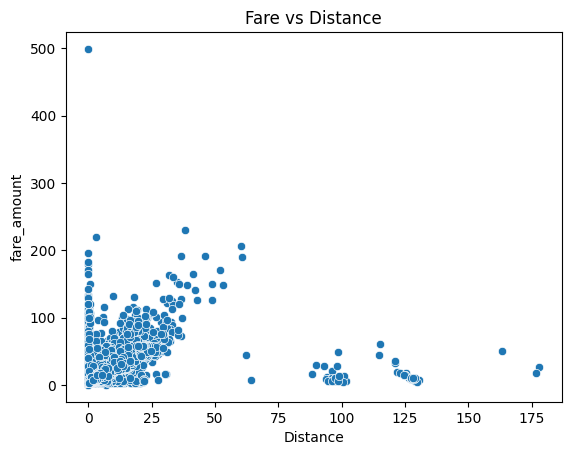


Model: Linear Regression
R-squared: 0.6041167920841171
RMSE: 0.6290054895695945
MAE: 0.27552329590959806

Model: Random Forest Regressor
R-squared: 0.6526650922872543
RMSE: 0.5891760869805488
MAE: 0.2917749687152693


In [ ]:
# ```python
# -------------------------------
# Practical 1 : Uber Fare Prediction using Linear Regression and Random Forest
# -------------------------------

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# -------------------------------
# Load and clean dataset
# -------------------------------
df = pd.read_csv("uber.csv")

# Drop unnecessary columns
df.drop(columns=['Unnamed: 0', 'key'], inplace=True, errors="ignore")

# Drop missing values
df.dropna(how='any', inplace=True)

# -------------------------------
# Outlier visualization (numeric columns)
# -------------------------------
for col in df.select_dtypes(exclude=['object']):
    plt.figure()
    sns.boxplot(data=df, x=col)
    plt.title(f"Boxplot of {col}")
    plt.show()

# -------------------------------
# Remove invalid values
# -------------------------------
df = df[
    (df.pickup_latitude > -90) & (df.pickup_latitude < 90) &
    (df.dropoff_latitude > -90) & (df.dropoff_latitude < 90) &
    (df.pickup_longitude > -180) & (df.pickup_longitude < 180) &
    (df.dropoff_longitude > -180) & (df.dropoff_longitude < 180) &
    (df.fare_amount > 0) &
    (df.passenger_count > 0) & (df.passenger_count < 50)
]

# -------------------------------
# Distance calculation
# -------------------------------
def distance(lat_1, lon_1, lat_2, lon_2):
    lon_1, lon_2, lat_1, lat_2 = map(np.radians, [lon_1, lon_2, lat_1, lat_2])
    diff_lon = lon_2 - lon_1
    diff_lat = lat_2 - lat_1
    km = 2 * 6371 * np.arcsin(
        np.sqrt(
            np.sin(diff_lat / 2.0) ** 2 +
            np.cos(lat_1) * np.cos(lat_2) * np.sin(diff_lon / 2.0) ** 2
        )
    )
    return km

df['Distance'] = distance(
    df['pickup_latitude'], df['pickup_longitude'],
    df['dropoff_latitude'], df['dropoff_longitude']
)

# Distance boxplot
plt.figure()
sns.boxplot(data=df, x='Distance')
plt.title("Boxplot of Trip Distances")
plt.show()

# Keep only realistic distances
df = df[(df['Distance'] < 200) & (df['Distance'] > 0)]

# -------------------------------
# Date-time features
# -------------------------------
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['week_day'] = df['pickup_datetime'].dt.day_name()
df['Year'] = df['pickup_datetime'].dt.year
df['Month'] = df['pickup_datetime'].dt.month
df['Hour'] = df['pickup_datetime'].dt.hour

# Drop raw lat/long and datetime
df.drop(columns=['pickup_datetime', 'pickup_latitude', 'pickup_longitude',
                 'dropoff_latitude', 'dropoff_longitude'], inplace=True)

# -------------------------------
# Feature engineering
# -------------------------------
def convert_week_day(day):
    if day in ['Monday', 'Tuesday', 'Wednesday', 'Thursday']:
        return 0  # Weekday
    return 1  # Weekend

def convert_hour(hour):
    if 5 <= hour <= 12:
        return 1  # Morning
    elif 12 < hour <= 17:
        return 2  # Afternoon
    elif 17 < hour < 24:
        return 3  # Evening
    return 0  # Night

df['week_day'] = df['week_day'].apply(convert_week_day)
df['Hour'] = df['Hour'].apply(convert_hour)

# -------------------------------
# Correlation and scatterplot
# -------------------------------
print(df.corr())
plt.figure()
sns.scatterplot(y=df['fare_amount'], x=df['Distance'])
plt.title("Fare vs Distance")
plt.show()

# -------------------------------
# Model preparation
# -------------------------------
x = df[['Distance']].values
y = df['fare_amount'].values.reshape(-1, 1)

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=10)

std_x = StandardScaler()
x_train = std_x.fit_transform(x_train)
x_test = std_x.transform(x_test)

std_y = StandardScaler()
y_train = std_y.fit_transform(y_train)
y_test = std_y.transform(y_test)

# -------------------------------
# Model evaluation function
# -------------------------------
def fit_predict(model, model_name):
    model.fit(x_train, y_train.ravel())
    y_pred = model.predict(x_test)
    r_squared = r2_score(y_test, y_pred)
    MSE = mean_squared_error(y_test, y_pred)
    RMSE = np.sqrt(MSE)
    MAE = mean_absolute_error(y_test, y_pred)
    print(f"\nModel: {model_name}")
    print("R-squared:", r_squared)
    print("RMSE:", RMSE)
    print("MAE:", MAE)


# -------------------------------
# Run models
# -------------------------------
fit_predict(LinearRegression(), "Linear Regression")
fit_predict(RandomForestRegressor(), "Random Forest Regressor")
# ```